# Lab 4 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Uso de Framework (TensorFlow) e K-Fold

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Classificação utilizando TensorFlow.
- Utilização do [*Stratified K-fold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).
- Cálculos de métircas

Data da entrega : 07/11

- Complete o código (marcado com 'ToDo') e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/Q2oLkLBJHCxyYgB26)
- Envie o *.ipynb* também.



# Preparação do ambiente e Tratamento dos dados

## Preparação do ambiente

### Importação das bibliotecas

Primeiro precisamos importar os pacotes. Vamos executar a célula abaixo para importar todos os pacotes que precisaremos.
- [*numpy*](www.numpy.org) é o pacote fundamental para a computação científica com Python.
- [*h5py*](http://www.h5py.org) é um pacote comum para interagir com um conjunto de dados armazenado em um arquivo H5.
- [*matplotlib*](http://matplotlib.org) é uma biblioteca famosa para plotar gráficos em Python.
- [*PIL*](http://www.pythonware.com/products/pil/) e [*scipy*](https://www.scipy.org/) são usados aqui para carregar as imagens e testar seu modelo final.
- [*Scikit Learn*](https://scikit-learn.org/) é um pacote muito utilizado para treinamento de modelos e outros algoritmos de *machine learning*.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from sklearn.metrics import accuracy_score

from tensorflow import keras

### Configurando os *plots* de gráficos

O próximo passo é configurar o *matplotlib* e a geração de valores aleatórios.

In [29]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configurando o Google Colab.

Configurando o Google Colab para acessar os nossos dados.

In [30]:
# Você vai precisar fazer o upload dos arquivos no seu drive (faer na pasta raiz) e montá-lo
# não se esqueça de ajustar o path para o seu drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregando e préprocessamento dos dados

In [31]:
# Função para ler os dados (gato/não-gato)
def load_dataset():
    def _load_data():
      train_dataset = h5py.File('drive/MyDrive/train_catvnoncat.h5', "r")
      train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
      train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

      test_dataset = h5py.File('drive/MyDrive/test_catvnoncat.h5', "r")
      test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
      test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

      classes = np.array(test_dataset["list_classes"][:]) # the list of classes
      train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
      test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

      return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

    def _preprocess_dataset(_treino_x_orig, _teste_x_orig):
      # Formate o conjunto de treinamento e teste dados de treinamento e teste para que as imagens
      # de tamanho (num_px, num_px, 3) sejam vetores de forma (num_px * num_px * 3, 1)
      _treino_x_vet = _treino_x_orig.reshape(_treino_x_orig.shape[0], -1) # ToDo: vetorizar os dados de treinamento aqui
      _teste_x_vet = _teste_x_orig.reshape(_teste_x_orig.shape[0], -1) # ToDo: vetorizar os dados de teste aqui

      # Normalize os dados (colocar no intervalo [0.0, 1.0])
      _treino_x = _treino_x_vet/255. # ToDo: normalize os dados de treinamento aqui
      _teste_x = _teste_x_vet/255. # ToDo: normalize os dados de teste aqui
      return _treino_x, _teste_x

    treino_x_orig, treino_y, teste_x_orig, teste_y, classes = _load_data()
    treino_x, teste_x = _preprocess_dataset(treino_x_orig, teste_x_orig)
    return treino_x, treino_y, teste_x, teste_y, classes

Carregando os dados

In [32]:
# Lendo os dados (gato/não-gato)
treino_x, treino_y, teste_x, teste_y, classes = load_dataset()

# Treinamento do modelo (85pt)

Há diversos frameworks para criação de modelos de *deep learning*, como [TensorFlow](https://www.tensorflow.org/) e [PyTorch](https://pytorch.org/). Nesta prática, usaremos o TensorFlow.


## Modelo 1: Testando um modelo com uma camada oculta com 8 neurônios (10pt)

Definição de um modelo com uma camada oculta (8 neurônios) e uma camada de saída com um neurônio (gato e não gato). Usaremos a ativação ReLU (*Retified Linear Unity*) na camada oculta e a *sigmoid* na camada de saída. Para classificação de classes 0 ou 1, pode-se ter um único neurônio de saída e deve-se usar a operação sigmoid antes de se calcular o custo (mean-squared error ou binary cross entropy).

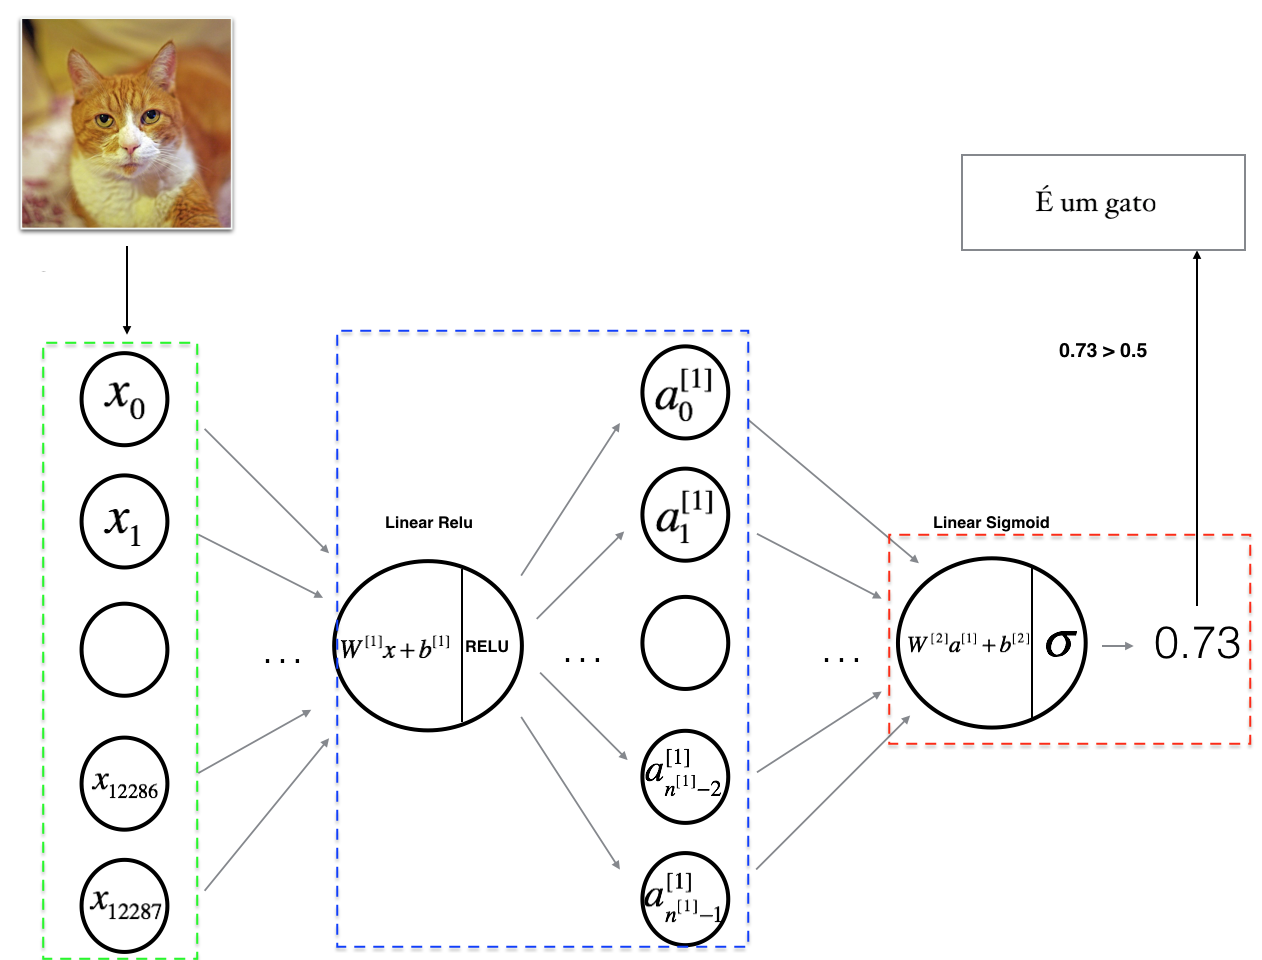
<caption><center> <u>Figura 7</u>: Rede neural com 2 camadas. <br> Resumo do modelo: ***ENTRADA -> LINEAR -> RELU -> LINEAR -> SIGMOID -> SAIDA***. </center></caption>

<!--
<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$.
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias).
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.
!-->

In [33]:
def treinar_modelo(modelo, x, y, epochs=100):
    # Setando a seed
    np.random.seed(10)

    # Compilando o modelo
    modelo.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics='accuracy')

    # Imprimindo a arquitetura da rede proposta
    modelo.summary()

    # Treinando o modelo
    modelo.fit(treino_x, treino_y.reshape(-1), epochs=epochs)
    return modelo

### ToDo: Definindo o modelo (5pt)

In [34]:
# Definição do modelo
def modelo_1():
  _model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(12288,)), # Adicione uma camada densa com 8 neurônios e ativação relu
    keras.layers.Dense(1, activation='sigmoid') # Adicione uma camada densa com 1 neurônio e ativação sigmoid
]) # Crie um modelo sequencial com keras.Sequential

  return _model

Treine o modelo e depois **use os parâmetros treinados** para classificar as imagens de treinamento e teste e verificar a acurácia.

### ToDo: Instanciando o modelo e testando (5pt)

In [35]:
np.random.seed(1)

# Criando o modelo
m1 = modelo_1() # ToDo: chame a função que define o modelo

# Treinando o modelo
m1 = treinar_modelo(m1, treino_x, treino_y, epochs = 100) # ToDo: Chame a função para treinar o modelo ----------------- X E Y??

# Predições nos dados de treino
y_train_pred = m1.predict(treino_x)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no treino
accuracy_train = accuracy_score(treino_y.reshape(-1), y_train_pred.reshape(-1))

# Predições nos dados de teste
y_test_pred = m1.predict(teste_x)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no teste
accuracy_test = accuracy_score(teste_y.reshape(-1), y_test_pred.reshape(-1))

print(f'\n\nAcurácia no treino: {accuracy_train}')
print(f'Acurácia no teste: {accuracy_test}')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 8)                 98312     
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                                 
Total params: 98321 (384.07 KB)
Trainable params: 98321 (384.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 5ms/step - loss: 0.8754 - accuracy: 0.5933
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.9336 - accuracy: 0.5646
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6352 - accuracy: 0.6507
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.5565 - accuracy: 0.6986
Epoch 5/100
7/7 [======

**Resultado esperado:**

```
  Acurácia treino = 81.34%
  Acurácia teste = 52.00%
```

## Modelo 2: Testando um modelo com uma camada oculta com 256 neurônios (15pt)

Crie um modelo com uma camada oculta (256 neurônios e ativação ReLu) e a camada de saída com um neurônio (ativação sigmoid).

### ToDo: Definição do modelo (10pt)

In [36]:
# Definição do modelo
def modelo_2():
  _model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(12288,)), # Adicione uma camada densa com 8 neurônios e ativação relu
    keras.layers.Dense(1, activation='sigmoid') # Adicione uma camada densa com 1 neurônio e ativação sigmoid
]) # Crie um modelo sequencial com keras.Sequential

  return _model

Agora treine e teste o seu modelo.

In [37]:
np.random.seed(10)

# Criando o modelo
m2 = modelo_2() # ToDo: chame a função que define o modelo

# Treinando o modelo
m2 = treinar_modelo(m1, treino_x, treino_y, epochs = 100) # ToDo: Chame a função para treinar o modelo ----------------- X E Y??

# Predições nos dados de treino
y_train_pred = m2.predict(treino_x)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no treino
accuracy_train = accuracy_score(treino_y.reshape(-1), y_train_pred.reshape(-1))

# Predições nos dados de teste
y_test_pred = m2.predict(teste_x)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no teste
accuracy_test = accuracy_score(teste_y.reshape(-1), y_test_pred.reshape(-1))

print(f'\n\nAcurácia no treino: {accuracy_train}')
print(f'Acurácia no teste: {accuracy_test}')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 8)                 98312     
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                                 
Total params: 98321 (384.07 KB)
Trainable params: 98321 (384.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 9ms/step - loss: 1.1550 - accuracy: 0.7321
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.2434 - accuracy: 0.9043
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1454 - accuracy: 0.9426
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1875 - accuracy: 0.9330
Epoch 5/100
7/7 [=====

**Resultado esperado:**

```
  Acurácia treino = 100.00%
  Acurácia teste = 70%
```

#### **ToDo:** Análise dos resultados (5pt)

Por que você obteve 100% no treino e apenas 80% no teste no segundo modelo e resultados piores no primeiro modelo?

```
O segundo modelo, com uma camada oculta de 256 neurônios, é mais
complexo do que o primeiro modelo, que tem apenas 8 neurônios.
Modelos mais complexos têm uma capacidade maior de se
ajustar aos dados de treino, o que pode resultar em uma
acurácia mais alta no treino.
```

## Modelo 3: Testando com uma rede com três camadas ocultas (15pt)

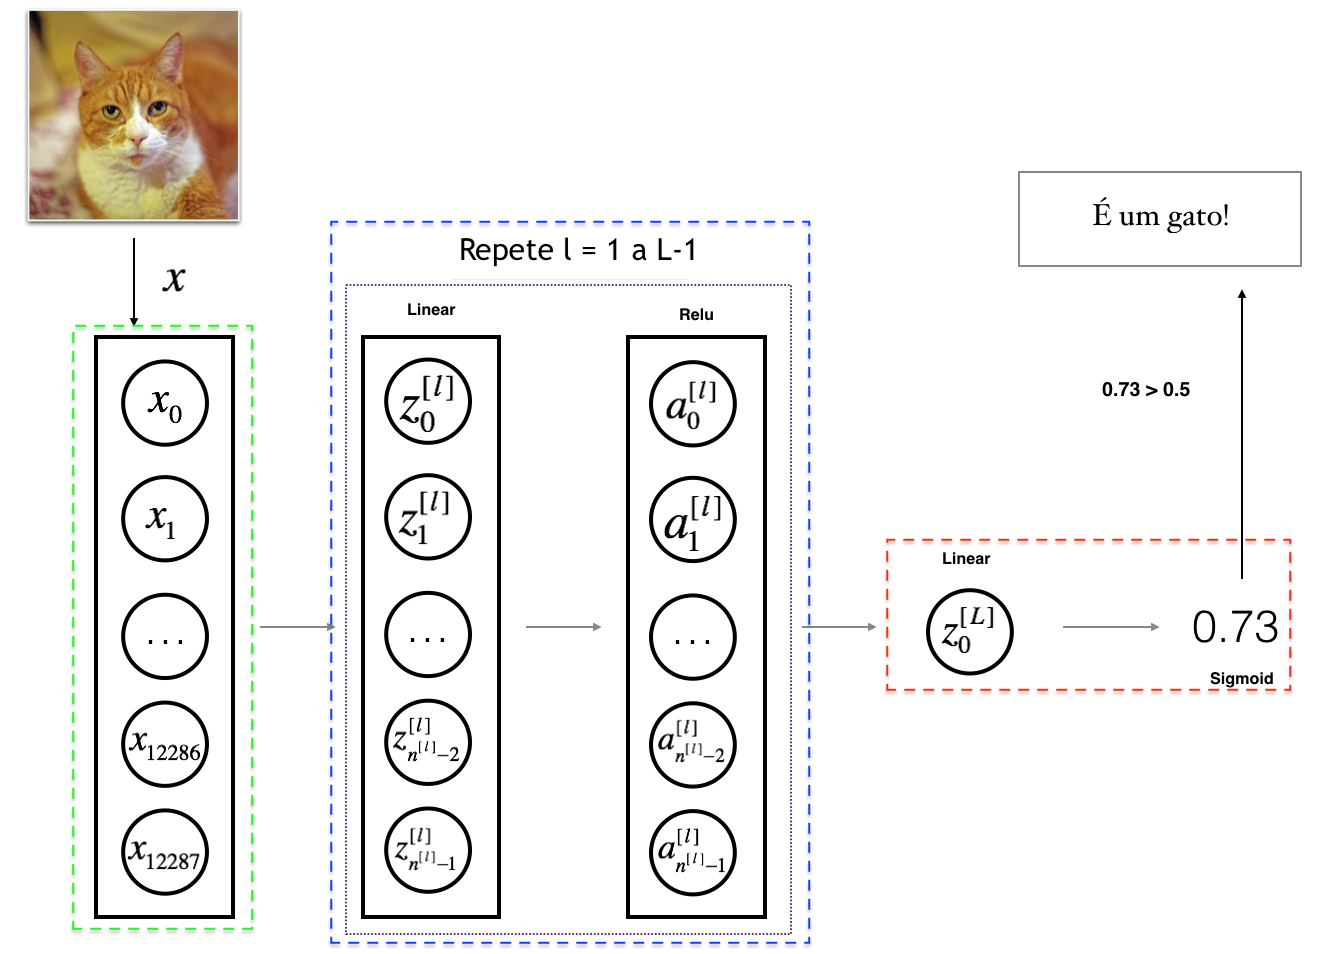
<caption><center> <u>Figura 8</u>: Rede neural com L camadas. <br> Resumo do modelo: ***ENTRADA -> LINEAR -> RELU -> LINEAR -> SIGMOID -> SAIDA***. </center></caption>

Crie um modelo com três camadas ocultas e a camada de saída com um neurônio.
Você deve seguir a seguinte estrutura:
1. Camada oculta 1 - 256 neurônios e ativação ReLU.
2. Camada oculta 2 - 64 neurônios e ativação ReLU.
3. Camada oculta 3 - 8 neurônios e ativação ReLU.
4. Camada de saída - 1 neurônio e ativação sigmoid.

### ToDo: Definição do modelo (10pt)

In [38]:
# Definição do modelo
def modelo_3():
  _model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(12288,)), # Adicione uma camada densa com 8 neurônios e ativação relu
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # Adicione uma camada densa com 1 neurônio e ativação sigmoid
]) # Crie um modelo sequencial com keras.Sequential

  return _model

Agora treine e teste o seu modelo.

In [39]:
np.random.seed(1)

# Criando o modelo
m3 = modelo_3() # ToDo: chame a função que define o modelo

# Treinando o modelo
m3 = treinar_modelo(m3, treino_x, treino_y, epochs = 100) # ToDo: Chame a função para treinar o modelo

# Predições nos dados de treino
y_train_pred = m3.predict(treino_x)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no treino
accuracy_train = accuracy_score(treino_y.reshape(-1), y_train_pred.reshape(-1))

# Predições nos dados de teste
y_test_pred = m3.predict(teste_x)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no teste
accuracy_test = accuracy_score(teste_y.reshape(-1), y_test_pred.reshape(-1))

print(f'\n\nAcurácia no treino: {accuracy_train}')
print(f'Acurácia no teste: {accuracy_test}')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               3145984   
                                                                 
 dense_53 (Dense)            (None, 64)                16448     
                                                                 
 dense_54 (Dense)            (None, 8)                 520       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3162961 (12.07 MB)
Trainable params: 3162961 (12.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 39ms/step - loss: 0.7101 - accuracy: 0.5885
Epoch 2/100
7/7 [==============================

**Resultado esperado:**

```
  Acurácia treino = 100.00%
  Acurácia teste = 76%
```

### **ToDo:** Análise dos resultados (5pt)

O resultado com três camadas ocultas foi melhor ou pior do que usa somente uma camada? Tente explicar os motivos.


```
O modelo com três camadas ocultas teve um desempenho pior no teste do que o modelo com uma camada oculta. Isso pode ser atribuído à
complexidade adicional introduzida pelas camadas extras, que pode ter levado a um overfitting.
```

## Testando uma rede que você desenvolveu (15pt)

Crie uma arquitetura e treine/teste o seu modelo

### ToDo: Definição do modelo (10pt)

In [40]:
# Definição do modelo
def meu_modelo():
  _model = keras.Sequential([
    #keras.layers.Dense(256, activation='relu', input_shape=(12288,)), # Adicione uma camada densa com 8 neurônios e ativação relu
    keras.layers.Dense(128, activation='relu', input_shape=(12288,)),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # Adicione uma camada densa com 1 neurônio e ativação sigmoid
]) # Crie um modelo sequencial com keras.Sequential

  return _model

In [41]:
np.random.seed(1)

# Criando o modelo
m4 = meu_modelo() # ToDo: chame a função que define o modelo

# Treinando o modelo
m4 = treinar_modelo(m4, treino_x, treino_y, epochs = 100) # ToDo: Chame a função para treinar o modelo ----------------- X E Y??

# Predições nos dados de treino
y_train_pred = m4.predict(treino_x)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no treino
accuracy_train = accuracy_score(treino_y.reshape(-1), y_train_pred.reshape(-1))

# Predições nos dados de teste
y_test_pred = m4.predict(teste_x)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

# Acurácia no teste
accuracy_test = accuracy_score(teste_y.reshape(-1), y_test_pred.reshape(-1))

print(f'\n\nAcurácia no treino: {accuracy_train}')
print(f'Acurácia no teste: {accuracy_test}')

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 128)               1572992   
                                                                 
 dense_57 (Dense)            (None, 32)                4128      
                                                                 
 dense_58 (Dense)            (None, 8)                 264       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1577393 (6.02 MB)
Trainable params: 1577393 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 21ms/step - loss: 0.8651 - accuracy: 0.4354
Epoch 2/100
7/7 [==============================] 

#### **ToDo:** Análise dos resultados (5pt)

O que você pode falar do seu modelo? Como ele se saiu em relação aos outros três modelos?


```
Os resultados obtidos no modelo que criei foram praticamente iguais aos
demais, com uma acurácia no treino de quase 100% e com acurácia no teste
de 70%, pode-se concluir que o modelo tem algum problema com
a generalização.
```

## Variando alguns hiperparâmetros (20pt)

Usando o framework do tensorflow/keras, altere os hiperparâmetros e veja o impacto (gere pelo menos dois novos modelos):

- learning rate.
- Algoritmo de otimização (SGD com momento, ADAM, ADADELTA, RMSPROP).
- inicialização dos pesos: inicialiação aleatória vs uniforme.
- Funções de ativação : troque a sigmoid por (ReLU, GELU, Leaky RELU).

**Você criar uma nova função para treinamento ou adaptar a existente**.

### ToDo: Desenvolva os seus modelos aqui (15pt)

In [43]:
### Início do código ###
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras import optimizers, initializers

# Definição do modelo
def meu_modelo(learning_rate, optimizer, weight_init, activation):
    if weight_init == 'random':
        initializer = initializers.RandomNormal()
    elif weight_init == 'uniform':
        initializer = initializers.RandomUniform()

    _model = keras.Sequential([
        keras.layers.Dense(128, activation=activation, input_shape=(12288,), kernel_initializer=initializer),
        keras.layers.Dense(32, activation=activation, kernel_initializer=initializer),
        keras.layers.Dense(8, activation=activation, kernel_initializer=initializer),
        keras.layers.Dense(1, activation=activation, kernel_initializer=initializer)
    ])

    # Configuração do otimizador
    if optimizer == 'SGD':
        opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'Adam':
        opt = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'Adadelta':
        opt = optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Otimizador não reconhecido.")

    # Compilação do modelo
    _model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return _model

# Definindo os hiperparâmetros que serão variados
learning_rates = [0.001, 0.01, 0.1]
optimizers_list = ['SGD', 'Adam', 'Adadelta', 'RMSprop']
weight_inits = ['random', 'uniform']
activations = ['relu', 'gelu', 'LeakyReLU']

# Loop para experimentar diferentes combinações de hiperparâmetros
for lr in learning_rates:
    for optimizer in optimizers_list:
        for weight_init in weight_inits:
            for activation in activations:
                print(f"Learning Rate: {lr}, Optimizer: {optimizer}, Weight Initialization: {weight_init}, Activation: {activation}")

                # Criando o modelo
                modelo = meu_modelo(learning_rate=lr, optimizer=optimizer, weight_init=weight_init, activation=activation)

                treino_y = treino_y.reshape(-1, 1)

                # Treinando o modelo
                treino_modelo = treinar_modelo(modelo, treino_x, treino_y, epochs=100)

                teste_y = teste_y.reshape(-1, 1)

                # Avaliando o modelo nos dados de teste
                acc_teste = modelo.evaluate(teste_x, teste_y, verbose=0)[1]

                print(f"Acurácia no teste: {acc_teste}")

### Fim do código ###

Learning Rate: 0.001, Optimizer: SGD, Weight Initialization: random, Activation: relu
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 128)               1572992   
                                                                 
 dense_65 (Dense)            (None, 32)                4128      
                                                                 
 dense_66 (Dense)            (None, 8)                 264       
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1577393 (6.02 MB)
Trainable params: 1577393 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 21ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


7/7 [==============================] - 2s 29ms/step - loss: 1.1874 - accuracy: 0.6507
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 0.7278 - accuracy: 0.5215
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.6615 - accuracy: 0.6268
Epoch 4/100
7/7 [==============================] - 0s 28ms/step - loss: 0.6662 - accuracy: 0.6459
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 0.6542 - accuracy: 0.6268
Epoch 6/100
7/7 [==============================] - 0s 28ms/step - loss: 0.6515 - accuracy: 0.6268
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 0.6541 - accuracy: 0.6411
Epoch 8/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6505 - accuracy: 0.6364
Epoch 9/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6519 - accuracy: 0.6124
Epoch 10/100
7/7 [==============================] - 0s 28ms/step - loss: 0.6457 - accuracy: 0.6316
Epoch 11/100
7/7 [=============

Acurácia no teste: 0.7799999713897705
Learning Rate: 0.001, Optimizer: SGD, Weight Initialization: uniform, Activation: LeakyReLU
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 128)               1572992   
                                                                 
 dense_85 (Dense)            (None, 32)                4128      
                                                                 
 dense_86 (Dense)            (None, 8)                 264       
                                                                 
 dense_87 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1577393 (6.02 MB)
Trainable params: 1577393 (6.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [

A saída de streaming foi truncada nas últimas 5000 linhas.
7/7 [==============================] - 0s 30ms/step - loss: 0.6326 - accuracy: 0.6411
Epoch 11/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6271 - accuracy: 0.6555
Epoch 12/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6227 - accuracy: 0.6555
Epoch 13/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6294 - accuracy: 0.6316
Epoch 14/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6401 - accuracy: 0.6316
Epoch 15/100
7/7 [==============================] - 0s 32ms/step - loss: 0.6128 - accuracy: 0.6459
Epoch 16/100
7/7 [==============================] - 0s 28ms/step - loss: 0.6136 - accuracy: 0.6555
Epoch 17/100
7/7 [==============================] - 0s 29ms/step - loss: 0.5991 - accuracy: 0.6459
Epoch 18/100
7/7 [==============================] - 0s 29ms/step - loss: 0.5835 - accuracy: 0.6316
Epoch 19/100
7/7 [==============================] - 0s 29ms/ste

#### **ToDo:** Analisando redes treinadas (5pt)

Qual combinação rendeu o melhor resultado? Tente explicar o por que.

```
Learning Rate: 0.1,
Optimizer: SGD,
Weight Initialization: uniform,
Activation: relu
Está combinação gerou um resultado de 100% de acurácia em treino e 80%
em teste devido a uma taxa de aprendizado maior como o 0.1, a
inicialização uniforme pode ter sido eficaz, a ativação ReLU
é boa para modelos com redes neurais mais profundas.
```

## Analisando outras métricas (10pt)

Nem sempre somente a acurácia é uma boa análise. Outras métricas podem ser úteis, como precisão, revocação e F1-Score. Para isso, considere os quatro modelos criados e os outros que você desenvolveu e avalie as métricas precisão, revocação e F1-Score.

In [44]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Desenvolva o código para calcular as métricas (5pt)

Após a importação do pacote, avalie cada uma das métricas para os modelos somente nos dados de teste.

In [48]:
### Início do código ###

# Defina uma função para calcular as métricas
def calcular_metricas(modelo, X, y):
    # Fazendo previsões
    y_pred = modelo.predict(X)
    y_pred = (y_pred > 0.5).astype(int)  # Convertendo para rótulos binários (0 ou 1)

    # Calculando as métricas
    precisao = precision_score(y, y_pred)
    revocacao = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    return precisao, revocacao, f1

# Agora, para cada modelo, calcule as métricas
modelos = [m1, m2, m3, m4]  # Substitua com os seus modelos

for i, modelo in enumerate(modelos, 1):
    # Fazendo previsões e calculando as métricas
    precisao, revocacao, f1 = calcular_metricas(modelo, teste_x, teste_y)

    print(f"Modelo {i}:")
    print(f"  Precisão: {precisao}")
    print(f"  Revocação: {revocacao}")
    print(f"  F1-Score: {f1}\n")

### Fim do código ###

2/2 [==============================] - 0s 5ms/step
Modelo 1:
  Precisão: 0.8076923076923077
  Revocação: 0.6363636363636364
  F1-Score: 0.7118644067796609

2/2 [==============================] - 0s 7ms/step
Modelo 2:
  Precisão: 0.8076923076923077
  Revocação: 0.6363636363636364
  F1-Score: 0.7118644067796609

2/2 [==============================] - 0s 10ms/step
Modelo 3:
  Precisão: 0.8125
  Revocação: 0.7878787878787878
  F1-Score: 0.8

2/2 [==============================] - 0s 8ms/step
Modelo 4:
  Precisão: 0.8636363636363636
  Revocação: 0.5757575757575758
  F1-Score: 0.6909090909090909



### ToDo: O que você pode falar sobre os modelos treinados (5pt)

```
Os modelos 1 e 2 dois diferem em relação ao tamanho da camada oculta, mas
podemos observar que no final não fez tanta diferença para as
métricas por causa da camada oculta ser única, diferente dos modelos 3
e 4 que tem mais camadas ocultas com os tamanhos diferentes, ocasionando
métricas diferentes, sendo a do modelo 3 a mais bem conceituada.
```

# *K-Fold* (15pt)

O método de validação cruzada denominado *k-fold* consiste em dividir o conjunto total de dados em *k* subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os *k-1* restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo.

A figura abaixo exemplifica um *3-fold*.



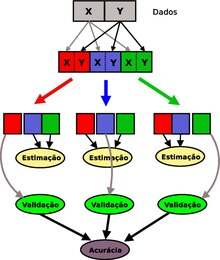


O *K-Fold* padrão divide nossos dados em *k* conjuntos sem prestar atenção no balanceamento dos dados, o que pode ocasionar com o que o seu modelo seja treinado somente com dados de uma classe e quando for testar, somente os dados da outra classe será usado, por exemplo. O [*Stratified K-Fold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) é uma alternativa, uma vez que faz a mesma coisa que o *K-Fold* mas com uma grande melhoria: obedece ao balanceamento (distribuição) dos labels.

### ToDo: Avaliando o *Stratified K-Fold* (10pt)

Escolha um dos modelos treinados e o aplique a estratégia do *Stratified K-Fold* usando somente os *dados de treino* e *k = 3*. Reporte as métricas de acurácia, precisão, revocação e F1-score para cada **K** e também a média com desvio padrão geral.

Dicas:
 - Utilize o *StratifiedKFold* presente na biblioteca *sklearn.model_selection*.
 - Você pode ter problemas de memória se seu modelo você for muito grande, por isso considere o uso do comando *del* do python.
 - Adapte o exemplo deste [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) para o problema dos gatos.
 - Utilize somente os dados de treino aqui.

In [51]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

# Carregue os dados
treino_x, treino_y, teste_x, teste_y, classes = load_dataset()

# Defina o número de folds
num_folds = 3

# Inicialize os arrays para armazenar as métricas
acuracias = []
precisoes = []
revocacoes = []
f1_scores = []

# Inicialize o StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Itere sobre os folds
for train_index, val_index in skf.split(treino_x, treino_y[0]):
    X_train, X_val = treino_x[train_index], treino_x[val_index]
    y_train, y_val = treino_y[0][train_index], treino_y[0][val_index]

    # Clone o modelo treinado
    modelo_clonado = keras.models.clone_model(m3)
    modelo_clonado.set_weights(m3.get_weights())

    # Treine o modelo clonado nos dados do fold atual
    treinar_modelo(modelo_clonado, X_train, y_train, epochs=100)

    # Faça as previsões no conjunto de validação
    y_pred = modelo_clonado.predict(X_val)
    y_pred = (y_pred > 0.5).astype(int)

    # Calcule as métricas
    acuracia = accuracy_score(y_val, y_pred)
    precisao = precision_score(y_val, y_pred)
    revocacao = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Armazene as métricas
    acuracias.append(acuracia)
    precisoes.append(precisao)
    revocacoes.append(revocacao)
    f1_scores.append(f1)

# Calcule a média e o desvio padrão das métricas
media_acuracias = np.mean(acuracias)
desvio_padrao_acuracias = np.std(acuracias)

media_precisoes = np.mean(precisoes)
desvio_padrao_precisoes = np.std(precisoes)

media_revocacoes = np.mean(revocacoes)
desvio_padrao_revocacoes = np.std(revocacoes)

media_f1_scores = np.mean(f1_scores)
desvio_padrao_f1_scores = np.std(f1_scores)

# Exiba os resultados
print(f"Acurácia: Média = {media_acuracias}, Desvio Padrão = {desvio_padrao_acuracias}")
print(f"Precisão: Média = {media_precisoes}, Desvio Padrão = {desvio_padrao_precisoes}")
print(f"Revocação: Média = {media_revocacoes}, Desvio Padrão = {desvio_padrao_revocacoes}")
print(f"F1-Score: Média = {media_f1_scores}, Desvio Padrão = {desvio_padrao_f1_scores}")


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               3145984   
                                                                 
 dense_53 (Dense)            (None, 64)                16448     
                                                                 
 dense_54 (Dense)            (None, 8)                 520       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3162961 (12.07 MB)
Trainable params: 3162961 (12.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 40ms/step - loss: 0.5161 - accuracy: 0.7512
Epoch 2/100
7/7 [==============================

### ToDo: Entendendo o *K-fold*.

Por que o *K-fold* pode ser uma estratégia mais robusta de análise do que a simples classificação ou divisão 80-20 dos dados (80% para treino e 20% para teste)? (5pt)

```
 K-Fold Cross Validation fornece uma visão mais abrangente do desempenho
 do modelo, reduzindo o impacto de variações nos dados e ajudando
 a evitar conclusões precipitadas sobre o desempenho do modelo.
```